In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from tqdm.auto import tqdm
from rl_analysis.plotting import setup_plotting_env, clean_ticks, savefig
from rl_analysis.io.df import dlight_exclude_toml

import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

## Let's plot out dopamine AUC to go with our plots

In [3]:
import toml

with open("../analysis_configuration.toml", "r") as f:
    analysis_config = toml.load(f)

In [4]:
raw_dirs = analysis_config["raw_data"]
proc_dirs = analysis_config["intermediate_results"]
transition_cfg = analysis_config["dlight_transition_features"]
dlight_cfg = analysis_config["dlight_common"]
figure_cfg = analysis_config["figures"]

In [5]:
# merge dlight stim features here...
from rl_analysis.util import get_snippets_vec

In [6]:
use_dct = dlight_exclude_toml(
    os.path.join(raw_dirs["dlight"], "dlight_photometry_processed_full.toml"),
    **analysis_config["dlight_common"],
    exclude_stim=False
)

In [7]:
use_dct = {k: v for k, v in use_dct.items() if v.get("session_number", 0) in [1, 2]}

In [8]:
dlight_df = pd.read_parquet(
    os.path.join(raw_dirs["dlight"], "dlight_photometry_processed_full.parquet"),
    filters=[("uuid", "in", list(use_dct.keys())), ("area", "=", "dls")],
).sort_index()
dlight_df = dlight_df.loc[dlight_df["stim_duration"] == 0.25].copy()

In [9]:
tqdm.pandas()

In [10]:
dlight_df["timestamps"] = dlight_df["timestamp"]

In [11]:
snippets = (
    dlight_df.groupby("uuid", observed=True, group_keys=True)
    .progress_apply(
        lambda x: get_snippets_vec(
            x,
            targets=[1.0],
            win=[5, 10],
            label_key="feedback_status",
            data_keys=["signal_reref_dff_z", "frame_index", "timestamps"],
            meta_keys=["mouse_id", "stim_duration"],
        )
    )
    .reset_index()
)

  0%|          | 0/100 [00:00<?, ?it/s]

In [12]:
snippets = snippets.dropna(subset=["x"])

In [13]:
snippets["x_sample"] = (snippets["x"] * 30.0).round().astype("int16")

In [14]:
uniq_idx = pd.factorize(list(zip(snippets["uuid"], snippets["snippet"])))[0]
snippets["uniq_idx"] = uniq_idx

In [15]:
time_frames = {"fast": (0, 0.3), "slow": (0.1, 5)}
stats = ["mean", "max", "min"]

In [16]:
lst = []
for _col_name, _time_frame in tqdm(time_frames.items()):
    _tmp = snippets.groupby("uniq_idx", observed=True).apply(
        lambda x: x.loc[x["x"].between(*_time_frame, inclusive="both")][
            "signal_reref_dff_z"
        ].agg(stats)
    )
    _tmp["range"] = _tmp["max"] - _tmp["min"]
    _tmp.columns = [f"{_col_name}_{_}" for _ in _tmp.columns]
    lst.append(_tmp)

  0%|          | 0/2 [00:00<?, ?it/s]

In [17]:
new_features = pd.concat(lst, axis=1)

In [18]:
snippets = snippets.drop(new_features.columns.intersection(snippets.columns), axis=1)
snippets = pd.merge(snippets, new_features, on="uniq_idx", how="left")

In [19]:
bins = pd.qcut(snippets["slow_mean"], ([0, 0.33, 0.66, 1]), labels=False)
snippets["bins"] = bins

In [20]:
custom_dlight_features = snippets.groupby("uuid")[new_features.columns].mean()

In [21]:
snippets["signal_reref_dff_z_diff"] = snippets.groupby("uniq_idx")[
    "signal_reref_dff_z"
].transform(lambda x: x.diff())

In [45]:
# RUN ONCE WITH EACH OF THESE FEATURES
use_signal = "signal_reref_dff_z_diff"
# use_signal = "signal_reref_dff_z"

pre_z = [-5, 0]

In [46]:
snippets["bins"] = 0

In [47]:
mus = snippets.loc[snippets["x"].between(*pre_z)].groupby("uniq_idx")[use_signal].mean()
sigs = snippets.loc[snippets["x"].between(*pre_z)].groupby("uniq_idx")[use_signal].std()

In [48]:
# any smoothing?
snippets = snippets.set_index("uniq_idx")
snippets[f"{use_signal}_z"] = (snippets[use_signal] - mus) / sigs
snippets = snippets.reset_index()

In [49]:
use_signal = f"{use_signal}_z"

In [50]:
# do we want to bootstrap for each bin?
use_duration = 0.25
nboots = 1000
boot_field = "uuid"

pre_snippets = snippets.loc[(snippets["x"] < 0) & (snippets["stim_duration"] == 0.25)][
    [boot_field, use_signal, "x", "bins"]
]
post_snippets = snippets.loc[(snippets["stim_duration"] == 0.25)][
    [boot_field, use_signal, "x", "bins"]
]

pool = pre_snippets[boot_field].unique()

pre_ci = []
ci = []
for _boot in tqdm(range(nboots)):
    indices = np.random.choice(pool, len(pool), replace=True)
    pre_ci.append(
        pre_snippets.loc[pre_snippets[boot_field].isin(indices)]
        .groupby(["bins", "x"])[use_signal]
        .mean()
        .groupby("bins")
        .apply(lambda x: x.abs().max())
    )
    ci.append(
        post_snippets.loc[post_snippets[boot_field].isin(indices)]
        .groupby(["bins", "x"])[use_signal]
        .mean()
    )

  0%|          | 0/1000 [00:00<?, ?it/s]

In [51]:
pre_ci = pd.concat(pre_ci, axis=1)
ci = pd.concat(ci)

In [52]:
use_sem = [0.025, 0.975]
use_pre = [0.025, 0.975]

In [53]:
plt_pre_ci = pre_ci.quantile([*use_pre], axis=1)
plt_pre_ci = plt_pre_ci.unstack().unstack()
plt_pre_ci.columns = ["low", "high"]
plt_pre_ci["low"] = -plt_pre_ci["high"]
plt_ci = ci.groupby(["bins", "x"]).quantile([*use_sem]).unstack()
plt_ci.columns = ["low", "high"]

In [54]:
plt_vals = post_snippets.groupby(["bins", "x"])[use_signal].mean()

In [55]:
setup_plotting_env()

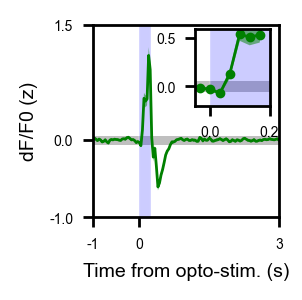

In [56]:
# make a separate plot for each bin
uniq_bins = snippets["bins"].dropna().unique()
fig, ax = plt.subplots(len(uniq_bins), 1, figsize=(1.2, 1.25), sharex=True, sharey=True)
try:
    iter(ax)
except:
    ax = np.array([ax])

line_kwargs = {"linestyle": "-", "marker": "o", "ms": 2.5, "color": "g"}

err_kwargs = {"alpha": 0.25, "color": "k", "zorder": -300, "edgecolor": None, "lw": 0}

ci_kwargs = {"alpha": 0.5, "color": "g", "edgecolor": None, "lw": 0}

for _bin, _ax in zip(uniq_bins, ax):
    # show full waveform
    _vals = plt_vals.loc[_bin]
    _ci = plt_ci.loc[_bin]
    _idx = _vals.index
    _ax.fill_between(
        _idx, plt_pre_ci.loc[_bin, "low"], plt_pre_ci.loc[_bin, "high"], **err_kwargs
    )
    _ax.fill_between(
        _idx, plt_ci.loc[_bin, "low"], plt_ci.loc[_bin, "high"], **ci_kwargs
    )
    _ax.plot(
        _idx, _vals.values, color=line_kwargs["color"], ls=line_kwargs["linestyle"]
    )
    _ax.set_xlim(-0.5, 3)
    if "diff" in use_signal:
        _ax.set_ylim(-1, 1.5)
    else:
        _ax.set_ylim(-1, 3)
    _ax.set_ylabel("dF/F0 (z)")
    _ax.set_xlabel("Time from opto-stim. (s)")
    ylimits = _ax.get_ylim()
    _ax.fill_between([0, 0.25], *ylimits, fc="b", alpha=0.2, zorder=-300)

    # zoom-in inset
    axins = _ax.inset_axes([0.55, 0.58, 0.4, 0.4])
    axins.fill_between(
        _idx, plt_pre_ci.loc[_bin, "low"], plt_pre_ci.loc[_bin, "high"], **err_kwargs
    )
    axins.fill_between(
        _idx, plt_ci.loc[_bin, "low"], plt_ci.loc[_bin, "high"], **ci_kwargs
    )
    axins.plot(_idx, _vals.values, **line_kwargs)
    axins.set_xlim([-0.05, 0.2])
    axins.set_ylim([-0.2, 0.6])

    ylimits = axins.get_ylim()
    axins.fill_between([0, 0.25], *ylimits, fc="b", alpha=0.2, zorder=-300)


clean_ticks(_ax, "y", precision=1, zero_symmetry=False)
clean_ticks(_ax, "x", precision=0, dtype=int, zero_symmetry=False)

savefig(
    fig,
    os.path.join(figure_cfg["store_dir"], f"optostim_response_{use_signal}"),
    bbox_inches="tight",
)

In [57]:
pre_session_amplitudes = (
    snippets.loc[snippets["x"].between(*pre_z)].groupby("uuid").mean()
)

/tmp/ipykernel_1437869/2864558806.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  snippets.loc[snippets["x"].between(*pre_z)].groupby("uuid").mean()


In [58]:
post_session_amplitudes = (
    snippets.loc[snippets["x"] >= 0].groupby(["x_sample", "uuid"]).mean()
)

/tmp/ipykernel_1437869/793294521.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  snippets.loc[snippets["x"] >= 0].groupby(["x_sample", "uuid"]).mean()


In [59]:
sample_to_time_map = post_session_amplitudes["x"]
sample_to_time_map = sample_to_time_map.loc[
    ~sample_to_time_map.index.duplicated(keep="first")
].dropna()

In [60]:
check_bins = post_session_amplitudes.index.get_level_values("x_sample").unique()

In [61]:
from scipy.stats import mannwhitneyu
from statsmodels.stats import multitest

In [62]:
use_test = mannwhitneyu

In [63]:
dcts = []
# convert bin number to string
for _bin in check_bins:

    dat1 = pre_session_amplitudes[use_signal].dropna().values
    dat2 = post_session_amplitudes.loc[_bin][use_signal].dropna().values

    stat, pval = use_test(
        dat1,
        dat2,
        alternative="less",
    )

    timepoint = str(np.around(sample_to_time_map.loc[_bin].iat[0], 3))
    dct = {}
    dct["stat"] = stat
    dct["p"] = pval
    dct["t"] = timepoint
    dct["test"] = str(use_test.__name__)
    dct["n1"] = len(dat1)
    dct["n2"] = len(dat2)
    dcts.append(dct)

In [64]:
pval_df = pd.DataFrame(dcts)
pval_df["p"] = multitest.multipletests(pval_df["p"], method="holm")[1]

In [65]:
import json

In [66]:
with open(
    os.path.join(proc_dirs["dlight"], f"opto_da_stim_timing_stats_{use_signal}.toml"),
    "w",
) as f:
    toml.dump(json.loads(json.dumps(pval_df.to_dict())), f)

In [67]:
pval_df

,stat,p,t,test,n1,n2
0,4590.0,1.000000e+00,0.0,mannwhitneyu,90,90
1,5220.0,1.000000e+00,0.033,mannwhitneyu,90,90
2,2610.0,5.629111e-03,0.067,mannwhitneyu,90,90
3,360.0,7.118505e-24,0.1,mannwhitneyu,90,90
4,630.0,1.971573e-20,0.133,mannwhitneyu,90,90
...,...,...,...,...,...,...
295,3420.0,1.000000e+00,9.833,mannwhitneyu,90,90
296,4410.0,1.000000e+00,9.867,mannwhitneyu,90,90
297,4230.0,1.000000e+00,9.9,mannwhitneyu,90,90
298,4230.0,1.000000e+00,9.933,mannwhitneyu,90,90
